In [1]:
import numpy as np
import tensorflow as tf
import keras
import cv2
from keras.layers import MaxPool2D,Conv2D,UpSampling2D,Input,Dropout
from keras.models import Sequential
from keras.preprocessing.image import img_to_array
import os
from tqdm import tqdm
import re
import matplotlib.pyplot as plt

In [ ]:
# to get the files in proper order
def sorted_alphanumeric(data):  
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)
# defining the size of the image
SIZE = 128
color_img = []
path = 'C:\\Users\\naman\\Desktop\\Image Project\\archive\\landscape Images\\color'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):    
    if i == '6000.jpg':
        break
    else:    
        img = cv2.imread(path + '/'+i,1)
        # open cv reads images in BGR format so we have to convert it to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #resizing image
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
        color_img.append(img_to_array(img))


gray_img = []
path = 'C:\\Users\\naman\\Desktop\\Image Project\\archive\\landscape Images\\gray'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):
     if i == '6000.jpg':
        break
     else: 
        img = cv2.imread(path + '/'+i,1)

        #resizing image
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
        gray_img.append(img_to_array(img))
         
   

 84%|████████▍ | 6000/7129 [00:46<00:08, 129.74it/s]


In [3]:
# defining function to plot images pair
def plot_images(color,grayscale):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('Color Image', color = 'green', fontsize = 20)
    plt.imshow(color)
    plt.subplot(1,3,2)
    plt.title('Grayscale Image ', color = 'black', fontsize = 20)
    plt.imshow(grayscale)
   
    plt.show()

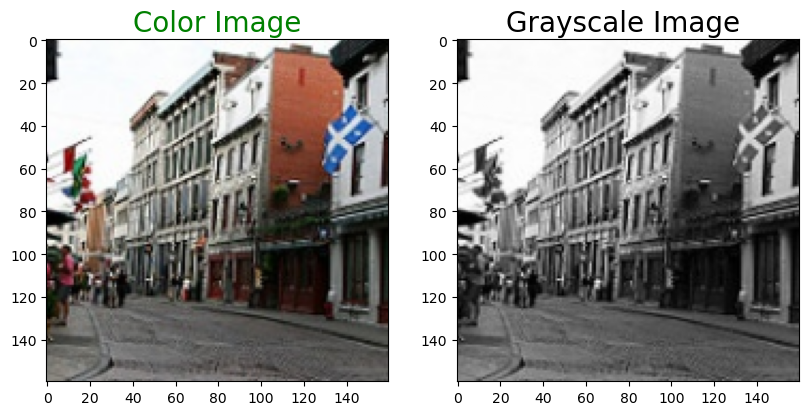

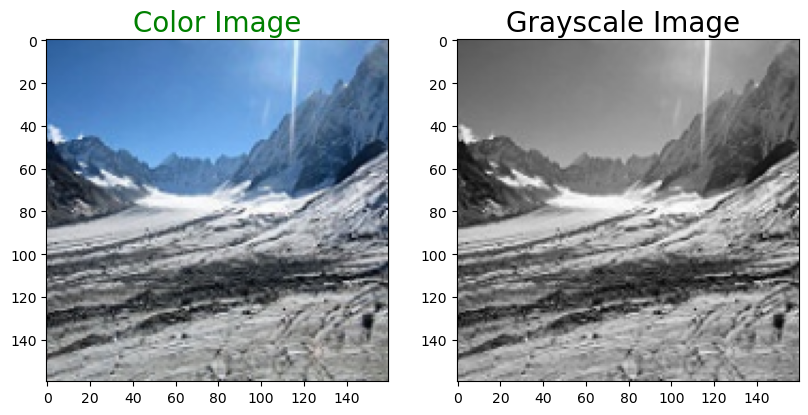

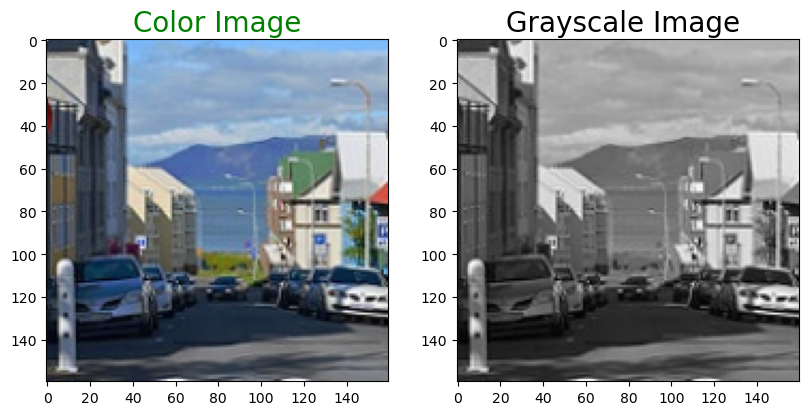

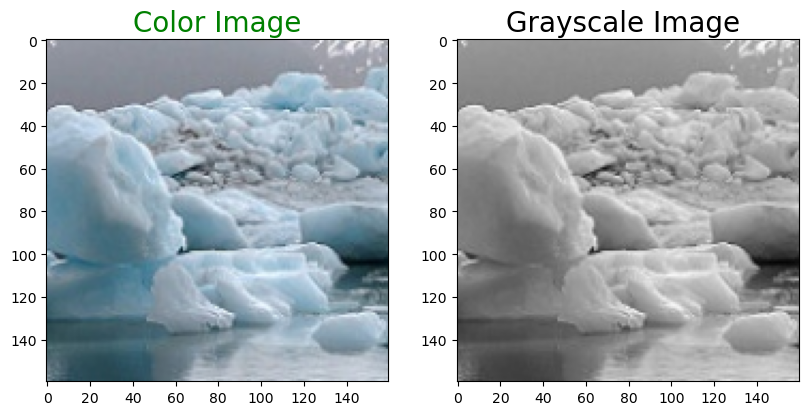

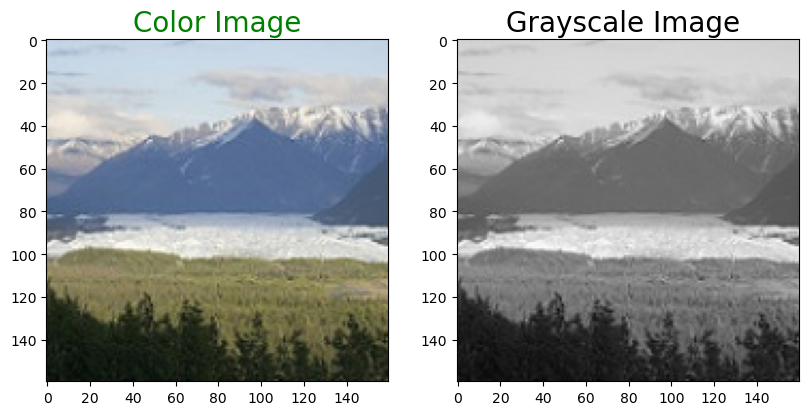

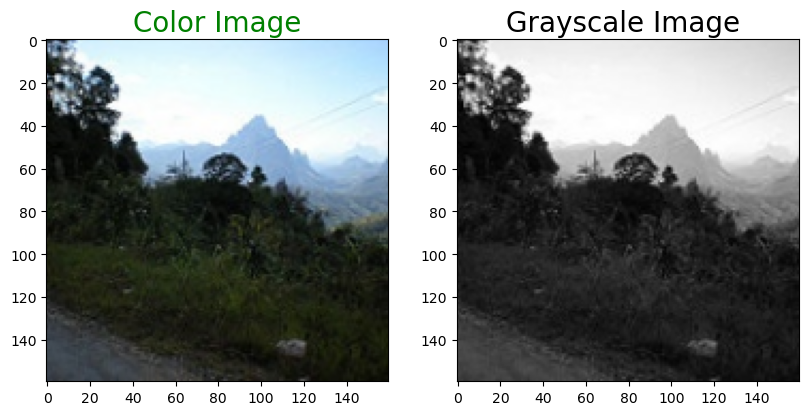

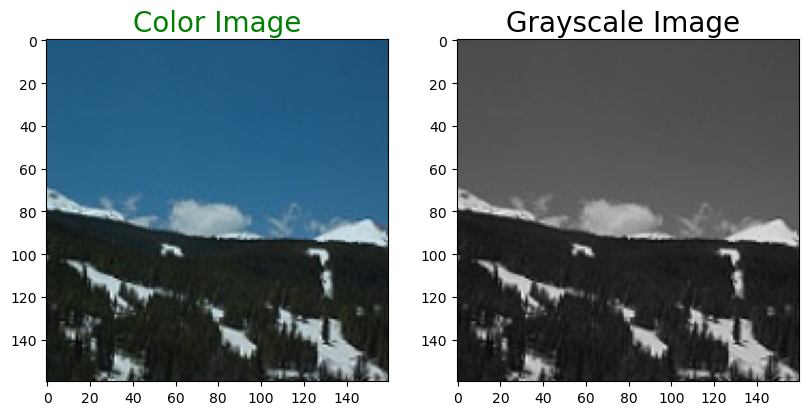

In [4]:
for i in range(3,10):
     plot_images(color_img[i],gray_img[i])

In [5]:
train_gray_image = gray_img[:5500]
train_color_image = color_img[:5500]

test_gray_image = gray_img[5500:]
test_color_image = color_img[5500:]
# reshaping
train_g = np.reshape(train_gray_image,(len(train_gray_image),SIZE,SIZE,3))
train_c = np.reshape(train_color_image, (len(train_color_image),SIZE,SIZE,3))
print('Train color image shape:',train_c.shape)


test_gray_image = np.reshape(test_gray_image,(len(test_gray_image),SIZE,SIZE,3))
test_color_image = np.reshape(test_color_image, (len(test_color_image),SIZE,SIZE,3))
print('Test color image shape',test_color_image.shape)

Train color image shape: (5500, 160, 160, 3)
Test color image shape (500, 160, 160, 3)


In [6]:
from keras import layers
def down(filters , kernel_size, apply_batch_normalization = True):
    downsample = tf.keras.models.Sequential()
    downsample.add(layers.Conv2D(filters,kernel_size,padding = 'same', strides = 2))
    if apply_batch_normalization:
        downsample.add(layers.BatchNormalization())
    downsample.add(keras.layers.LeakyReLU())
    return downsample


def up(filters, kernel_size, dropout = False):
    upsample = tf.keras.models.Sequential()
    upsample.add(layers.Conv2DTranspose(filters, kernel_size,padding = 'same', strides = 2))
    if dropout:
        upsample.dropout(0.2)
    upsample.add(keras.layers.LeakyReLU())
    return upsample


In [ ]:
# #increase the 

# def model():
#     inputs = layers.Input(shape= [160,160,3])
#     d1 = down(128,(3,3),False)(inputs)
#     d2 = down(128,(3,3),False)(d1)
#     d3 = down(256,(3,3),True)(d2)
#     d4 = down(512,(3,3),True)(d3)
    
#     d5 = down(512,(3,3),True)(d4)
#     #upsampling
#     u1 = up(512,(3,3),False)(d5)
#     u1 = layers.concatenate([u1,d4])
#     u2 = up(256,(3,3),False)(u1)
#     u2 = layers.concatenate([u2,d3])
#     u3 = up(128,(3,3),False)(u2)
#     u3 = layers.concatenate([u3,d2])
#     u4 = up(128,(3,3),False)(u3)
#     u4 = layers.concatenate([u4,d1])
#     u5 = up(3,(3,3),False)(u4)
#     u5 = layers.concatenate([u5,inputs])
#     output = layers.Conv2D(3,(2,2),strides = 1, padding = 'same')(u5)
#     return tf.keras.Model(inputs=inputs, outputs=output)
def model():
    inputs = layers.Input(shape=[160,160,3])

    # Encoder
    d1 = down(128, (3,3), False)(inputs)
    d2 = down(256, (3,3), False)(d1)
    d3 = down(512, (3,3), True)(d2)
    d4 = down(512, (3,3), True)(d3)
    d5 = down(1024, (3,3), True)(d4)

    # Optional attention at bottleneck
    # att = layers.MultiHeadAttention(num_heads=4, key_dim=64)(d5, d5)
    # att = layers.Add()([att, d5])  # residual

    # Decoder
    u1 = up(512, (3,3), False)(d5)
    u1 = layers.concatenate([u1, d4])
    u2 = up(256, (3,3), False)(u1)
    u2 = layers.concatenate([u2, d3])
    u3 = up(128, (3,3), False)(u2)
    u3 = layers.concatenate([u3, d2])
    u4 = up(128, (3,3), False)(u3)
    u4 = layers.concatenate([u4, d1])
    u5 = up(64, (3,3), False)(u4)

    # Output layer
    output = layers.Conv2D(3, (2,2), activation='sigmoid', padding='same')(u5)

    return tf.keras.Model(inputs=inputs, outputs=output)


In [8]:
model = model()
model.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 80, 80,    │      3,584 │ input_layer[0][0] │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 40, 40,    │    147,584 │ sequential[0][0]  │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, 20, 20,    │    296,192 │ sequential_1[0][… │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_3        │ (None, 10, 10,    │  1,182,208 │ sequential_2[0][… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_4        │ (None, 5, 5, 512) │  2,361,856 │ sequential_3[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_5        │ (None, 10, 10,    │  2,359,808 │ sequential_4[0][… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 10, 10,    │          0 │ sequential_5[0][… │
│ (Concatenate)       │ 1024)             │            │ sequential_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_6        │ (None, 20, 20,    │  2,359,552 │ concatenate[0][0] │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 20, 20,    │          0 │ sequential_6[0][… │
│ (Concatenate)       │ 512)              │            │ sequential_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_7        │ (None, 40, 40,    │    589,952 │ concatenate_1[0]… │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 40, 40,    │          0 │ sequential_7[0][… │
│ (Concatenate)       │ 256)              │            │ sequential_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_8        │ (None, 80, 80,    │    295,040 │ concatenate_2[0]… │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 80, 80,    │          0 │ sequential_8[0][… │
│ (Concatenate)       │ 256)              │            │ sequential[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_9        │ (None, 160, 160,  │      6,915 │ concatenate_3[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 160, 160,  │          0 │ sequential_9[0][… │
│ (Concatenate)       │ 6)                │            │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 160, 160,  │         75 │ concatenate_4[0]

 Total params: 9,602,766 (36.63 MB)

 Trainable params: 9,600,206 (36.62 MB)

 Non-trainable params: 2,560 (10.00 KB)

### Fitting our model

In [9]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'mean_absolute_error',
              metrics = ['acc'])

model.fit(train_g, train_c, epochs = 50,batch_size = 50,verbose = 0)

In [10]:
model.evaluate(test_gray_image,test_color_image)

16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 306ms/step - acc: 0.5618 - loss: 0.0485


[0.04852134734392166, 0.5618404746055603]

# plotting colorized image along with grayscale and color image

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


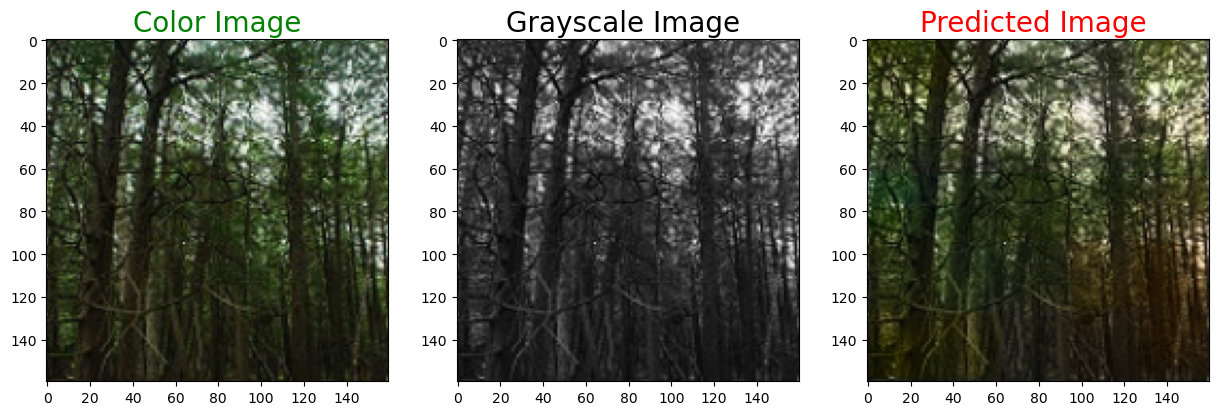

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


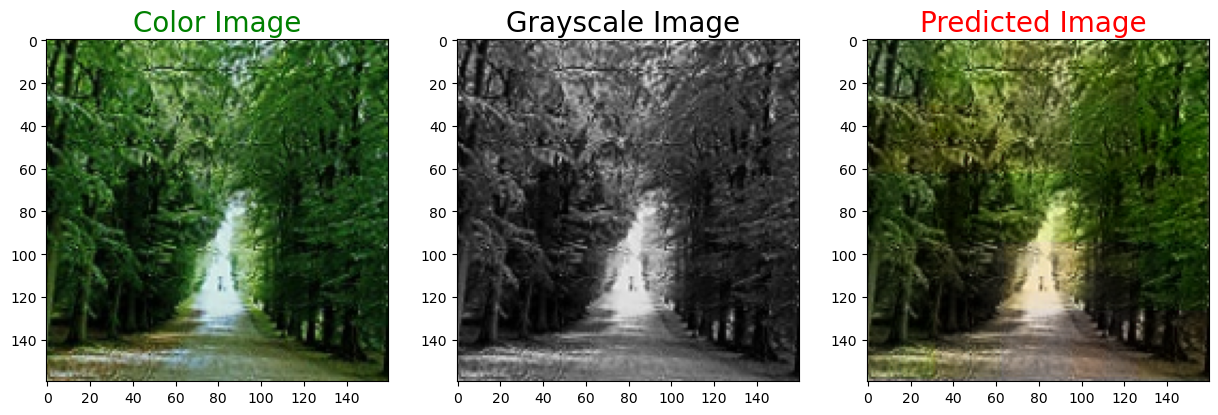

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


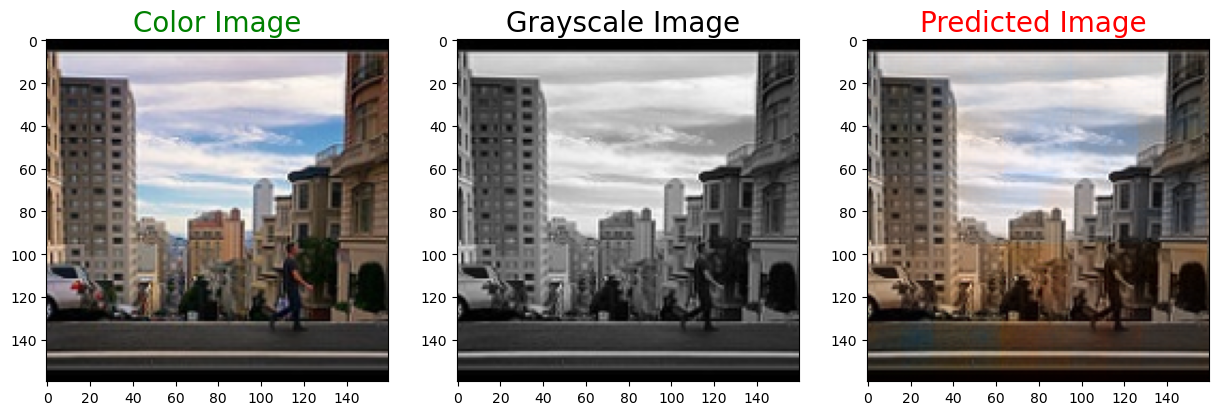

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


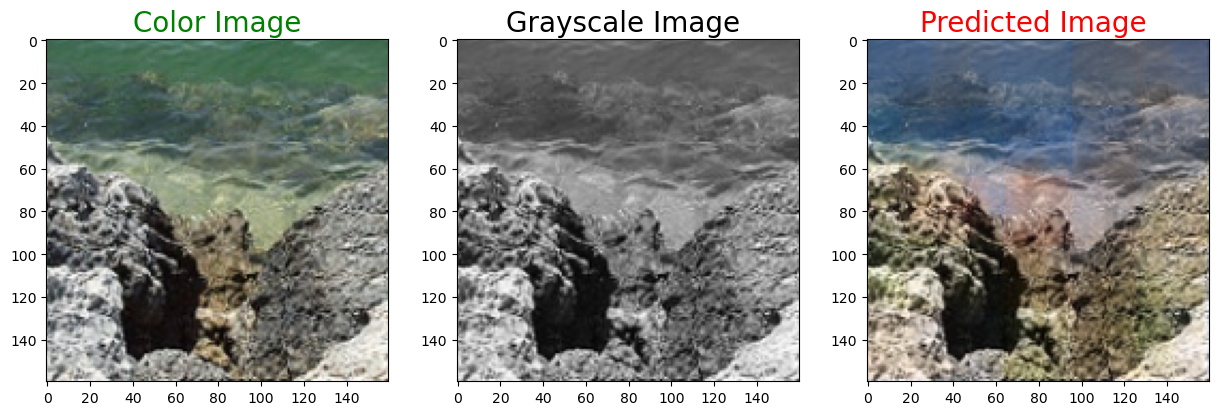

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


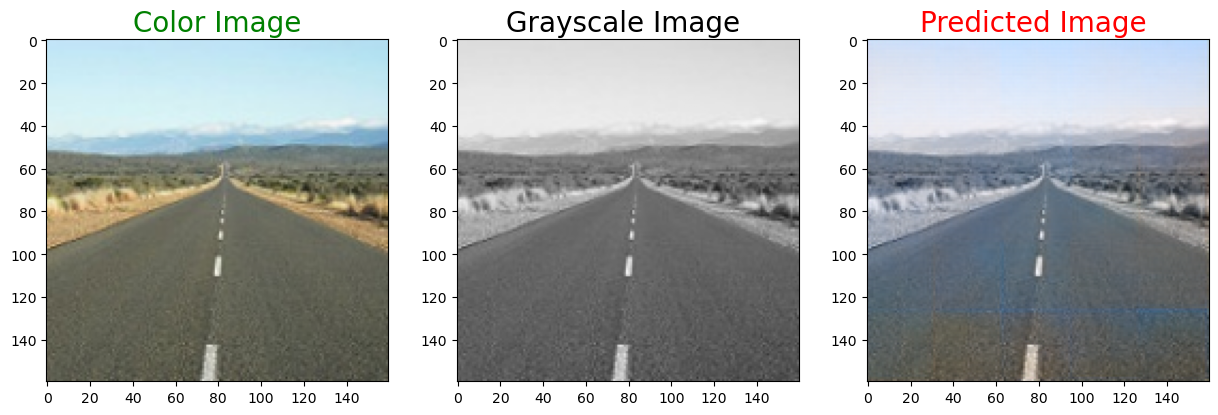

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


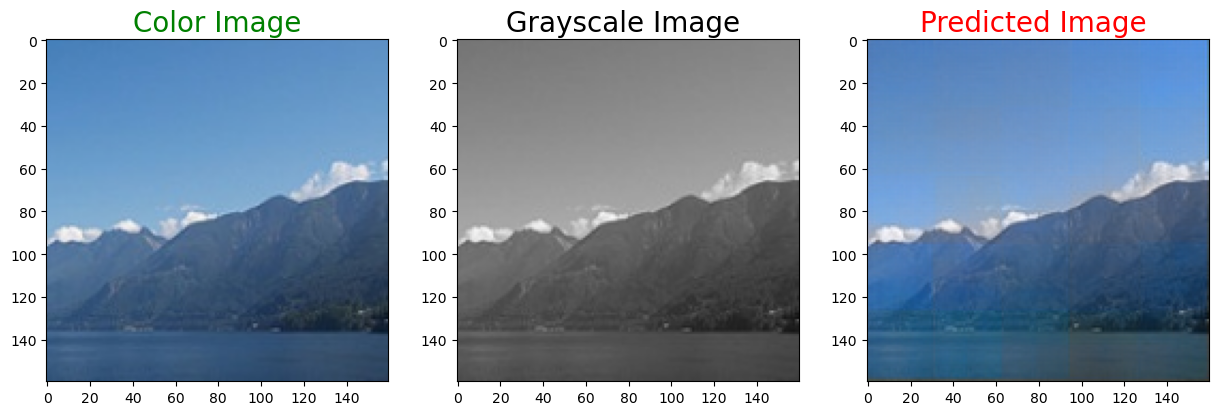

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


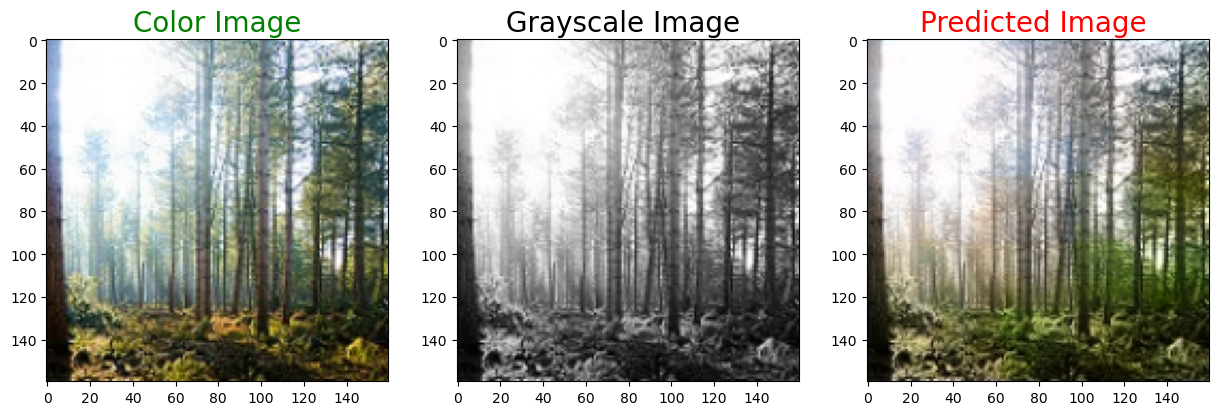

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


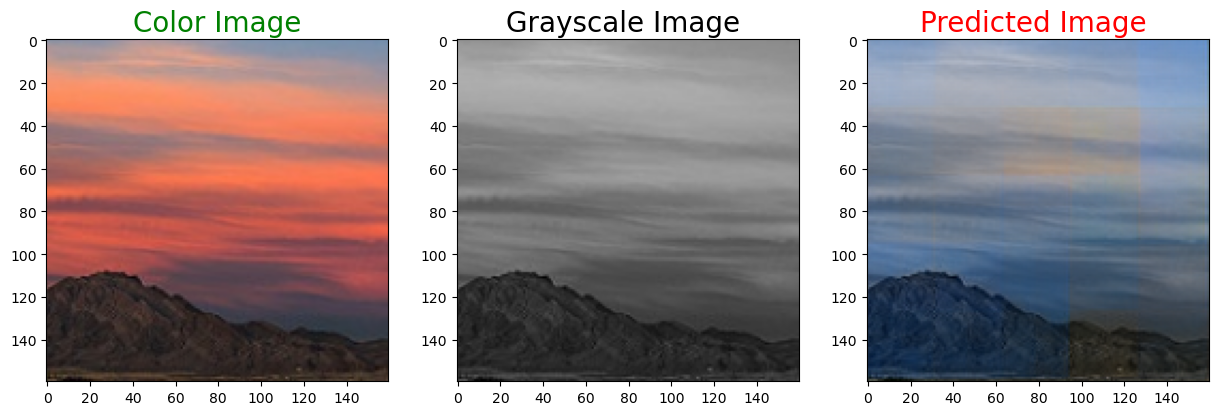

In [11]:
# defining function to plot images pair
def plot_images(color,grayscale,predicted):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('Color Image', color = 'green', fontsize = 20)
    plt.imshow(color)
    plt.subplot(1,3,2)
    plt.title('Grayscale Image ', color = 'black', fontsize = 20)
    plt.imshow(grayscale)
    plt.subplot(1,3,3)
    plt.title('Predicted Image ', color = 'Red', fontsize = 20)
    plt.imshow(predicted)
   
    plt.show()

for i in range(50,58):
    predicted = np.clip(model.predict(test_gray_image[i].reshape(1,SIZE, SIZE,3)),0.0,1.0).reshape(SIZE, SIZE,3)
    plot_images(test_color_image[i],test_gray_image[i],predicted)

 

In [14]:
model.save("autoenc_model.h5")

In [1]:
import gradio as gr
import numpy as np
from PIL import Image
import tensorflow as tf

# Load your trained model
model = tf.keras.models.load_model("autoenc_model.h5")

def preprocess_image(img):
    if img is None:
        raise ValueError("Please upload an image before proceeding.")
    if not isinstance(img, Image.Image):
        img = Image.open(img)
    img = img.convert("L")
    img = img.resize((160, 160))
    img = np.array(img) / 255.0
    img = np.expand_dims(img, axis=-1)
    img = np.repeat(img, 3, axis=-1)
    img = np.expand_dims(img, axis=0)
    return img

def colorize_image(input_image):
    try:
        input_tensor = preprocess_image(input_image)
        predicted = model.predict(input_tensor)
        output = (predicted[0] * 255).astype(np.uint8)
        return Image.fromarray(output)
    except Exception as e:
        return f"Error: {e}"

demo = gr.Interface(
    fn=colorize_image,
    inputs=gr.Image(type="pil", label="Upload Grayscale Image"),
    outputs=gr.Image(type="pil", label="Colorized Image"),
    title="Image Colorization",
    description="Upload a grayscale image to colorize it!"
)

demo.launch(share=True)


* Running on local URL:  http://127.0.0.1:7862

Could not create share link. Please check your internet connection or our status page: https://status.gradio.app.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
